> <b>参考自：[all-agentic-architectures](https://github.com/FareedKhan-dev/all-agentic-architectures/tree/main)</b>

# Tool Use (工具调用架构)

## 1. 定义 (Definition)
**Tool Use** 是一种赋予大语言模型（LLM）驱动的智能体（Agent）调用外部函数或 API 能力的架构。
* **自主性**：智能体会自主判断用户问题是否超出了其内部知识范围。
* **决策性**：智能体能够决定在何时、调用哪一个特定的工具来获取必要的信息。

---

## 2. 宏观工作流 (Workflow)
工具调用的过程遵循“接收-决策-执行-观察-综合”的循环：

1.  **接收请求 (Receive Query)**：智能体接收来自用户的原始指令。
2.  **决策阶段 (Decision)**：分析查询内容及可用工具列表，判断是否需要外部工具协助。
3.  **执行动作 (Action)**：若需要工具，智能体按格式要求生成调用指令（如特定函数名及参数）。
4.  **获取观察 (Observation)**：系统执行该调用，并将结果（即“观察到的数据”）反馈给智能体。
5.  **综合输出 (Synthesis)**：智能体将工具返回的信息整合进推理过程中，生成最终的、有据可依的回答。



---

## 3. 应用场景 (Use Cases)
* **研究助手**：通过调用网络搜索 API，回答需要**即时信息**的问题。
* **企业级助手**：通过查询公司内部数据库，回答如“上周新增用户数”等**业务数据**问题。
* **科学与数学任务**：利用计算器或 WolframAlpha 等**计算引擎**，处理模型自身不擅长的精确计算。

---

## 4. 优缺点分析 (Pros & Cons)

### ✅ 优点
* **事实增强 (Factual Grounding)**：通过获取实时数据，显著减少模型的“幻觉”现象。
* **可扩展性 (Extensibility)**：只需添加新工具，即可不断扩展智能体的能力边界。

### ❌ 缺点
* **集成成本 (Integration Overhead)**：需要精细的“管道”工程，包括定义接口、处理 API 密钥以及管理工具失效的情况。
* **工具信任 (Tool Trust)**：回答的质量高度依赖于工具的准确性；如果工具提供错误信息，智能体也难以产出正确答案。

# 0、基础和配置

## 0.1 安装核心依赖
在构建基于工具调用的智能体前，我们需要安装一套标准库。这些库分别负责任务编排、环境变量管理、结果展示以及外部工具接入。

### 🛠️ 需要安装的库及其作用
| 库名称 | 作用描述 |
| :--- | :--- |
| **`langchain-openai`** | 用于与 OpenAI 的模型（如 GPT-4）进行交互的 LangChain 集成库。 |
| **`langgraph`** | 用于构建有状态的、多参与者（Multi-agent）应用的库，支持创建复杂的循环工作流。 |
| **`python-dotenv`** | 用于从 `.env` 文件中读取 API 密钥等环境变量，保护敏感信息。 |
| **`rich`** | 一个 Python 库，用于在终端输出格式漂亮、带颜色的文本和表格，方便调试。 |
| **`tavily-python`** | **核心搜索工具**。Tavily 是专为 AI 智能体设计的搜索引擎，能够返回结构化的搜索结果。 |

### 💻 安装命令
你可以通过以下 pip 命令一键安装所有依赖：

```bash
pip install -U langchain-openai langchain langgraph python-dotenv rich tavily-python langchain_community pydantic

In [14]:
%pip install -U langchain-openai langchain langgraph python-dotenv rich tavily-python langchain_community pydantic


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: /Users/okonma/Desktop/PyProj/AgentArchitechtures/.venv/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## 0.2 导入库并设置密钥

在这一步中，我们将导入核心模块，并使用 `python-dotenv` 安全地加载 API 密钥。

### 🔑 必需的 API 密钥
为了让智能体正常工作，你需要准备以下三类 Key：
1.  **OpenAI Key**：驱动大语言模型（LLM）进行推理和决策。
2.  **LangSmith Key**：用于**追踪（Tracing）**。它可以记录智能体的每一步运行轨迹，是调试和优化 Agent 复杂逻辑的必备工具。
3.  **Tavily Key**：赋予智能体联网搜索的能力。

In [15]:
import os
import json
from  typing import List, Annotated, TypedDict, Optional
from dotenv import load_dotenv

# LangChain组件
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage, ToolMessage
from pydantic import BaseModel, Field

# LangGraph组件
from langgraph.graph import StateGraph, END
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.prebuilt import ToolNode

# 输出美化
from rich.console import Console
from rich.markdown import Markdown

# API密钥
load_dotenv()

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Tool Use"

for key in ["OPENAI_API_KEY", "LANGCHAIN_API_KEY", "DASHSCOPE_API_KEY", "TAVILY_API_KEY"]:
    if not os.environ.get(key):
        print(f"{key} not found.")

print("Keys loaded successfully.")

Keys loaded successfully.


# 1、创建 Agent 工具

## 1.1 创建并测试 Web Search 工具

在这一阶段，我们将实例化 `TavilySearchResults` 工具。这是智能体与外部世界连接的第一个通道。

### 🎯 核心概念：描述的重要性
定义工具时，最关键的部分是它的**描述（Description）**。
* **决策依据**：LLM 并不通过底层代码了解工具，而是阅读这段**自然语言描述**。
* **精准引导**：一个清晰、准确的描述能告诉 LLM 该工具的功能、适用场景以及参数含义。如果描述模糊，Agent 可能会在不该调用时误用，或在需要时忽略它。

In [16]:
# 初始化工具，可以设置最多的结果数量以保证上下文的精简
search_tool = TavilySearchResults(max_results=2)

# 给工具定义清楚的工具名和描述是很重要的
search_tool.name = "web_search"
search_tool.description = "A tool that can be used to search the internet for up-to-date information on any topic, including news, events, and current affairs."

tools=[search_tool]
print(f"Tool '{search_tool.name}' created with description: '{search_tool.description}'")

console = Console()

# 直接测试工具并观察它的输出格式
print("\n--- Testing the tool directly ---")
test_query = "常熟阿诺头为什么尖尖的?"
test_result = search_tool.invoke({"query": test_query})
console.print(f"[bold green]Query:[/bold green] {test_query}")
console.print("\n[bold green]Result:[/bold green]")
console.print(test_result)

Tool 'web_search' created with description: 'A tool that can be used to search the internet for up-to-date information on any topic, including news, events, and current affairs.'

--- Testing the tool directly ---


Query: 常熟阿诺头为什么尖尖的?

Result:

[
    {
        'title': '全网烂梗最多的健身网红，终于把自己练成了人类最抽象的样子',
        'url': 'https://news.qq.com/rain/a/20240815A09QQ700',
        'content': '> 
那我问你，你是男的女的，如果你是女的你说这样的话啊，那我问你，你你你是女孩子那我问你，那那你那你头顶是不是是不是尖
的，那我那我问你，你头顶是尖的呢，还是秃顶的啊，还是染黄色染红色的，那我问你，啊，还是戴假发的，如果是你如果你是男
的，那我问你啊，你说我的头是尖的，那我问你，那你是不是秃头，那你是不是光头啊，你是光头还是有头发的啊，那我问你，我
头顶，我头尖怎么了，我就尖怎么了，哎我头尖怎么了，我就头顶尖怎么了，我就头顶尖你难道你看不惯吗，啊我头顶就是尖的怎
么了我就是尖，我就是要尖怎么了啊，你看不惯吗，啊那我问你......\n\n他对一场比赛是否在常熟举办，也发表了自己的独到见
解，爱因斯坦听见都得修改相对论。不过说句公道话，诺神这里只是不小心省略了主语，他实际想表达的意思应该是“传言常熟可能
举办DMS，但是他看来常熟举办DMS不太可能”。\n\n当观众问他健身用什么补剂，诺神表示自己连蛋白粉都不用的，最多也就用点蛋
白粉。\n\n谈到相亲相爱的师傅李亚强，诺神更是表示两人的关系血浓于水，“师父对待我就像父亲一样看待”。 [...] 
所以，只有以下两种可能性。要么诺神是自宇宙开天辟地以来，抗药能力最强的碳基生物，是比太上老君更给劲的人体炼丹炉；要
么诺神买到了假药还天天吃，不能说没有一点效果，但作用在脑壳上的效果，比肌肉更明显。\n\n据说群勃龙会对大脑产生各种未
知后果，导致类如阿兹海默症等精神疾病，又或者诺神本就在语言方面天赋异禀，逻辑远超常人。时间久了，常熟阿诺的各种语录
也开始在网上流传，俗称“诺言诺语”。\n\n比如，当阿诺被问到头顶怎么尖尖的，诺神反手回问了一百个“那我问你”。一顿下来嘴
巴先力竭了，今天的训练量又达标了。\n\n完整版如下： [...] 
不同于丁真、范马家族等草根抽象人物，常熟阿诺的家境其实相当富裕，属于官三代+富三代的王炸开局。按照寻常发展轨迹，阿诺
本该会完全凭借自己的努力奋斗，考进常熟当地的某国家单位，完全没必要转行健美，走一条最艰难的路。\n\n但网上一些关于阿
诺的过往轶事，或许揭露了背后的原因。据称，诺神打上小学起，就展现出了惊人的学习天赋，属于每门课考试都爆砍个位数的那
种，发展十分均衡。这也让某些不合理变成了合理。\n\n在毕业之后，诺神还是在家人的安排下，和李老八一样，成为了一名光荣
的辅警。然而据说他却在扫黄打非行动中，暗中给小姐姐们通风报信。也因其过于超前的意识形态，最终连辅警这条路也走不通了
。\n\n所以，不管因为个人的奋斗，还是历史的进程，常熟阿诺可能天生就该吃健美这碗饭。此后诺神化悲愤为力量，潜心专研健
身，并凭借稀世罕见的天赋和意志力，率先为健美圈带来了变革。\n\n常熟阿诺的成名之战，是他瞒着第一任师傅钱升，参加上海
健美比赛的事情。给可能不了解的朋友科普一下，健美运动员在参加比赛前，需要通过长时间的严苛训练，将体脂率降低到只有个
位数，并让身体大量脱水，从而凸显出肌肉线条，也就是俗称的“备赛”。',
        'score': 0.9993436
    },
    {
        'title': '一人揭露整個健美圈亂象！頭頂尖尖的阿諾爲啥成爲最抽象網紅？',
        'url': 'https://www.youtube.com/watch?v=MSu0yyVYzbg',
        'content': '# 一人揭露整個健美圈亂象！頭頂尖尖的阿諾爲啥成爲最抽象網紅？\n## 阿姨洗铁路丶\n6320 
subscribers\n1676 likes\n\n### Description\n127471 views\nPosted: 16 Mar 2025\n\n160 comments\n### Transcript:',
        'score': 0.996852
    }
]

### 📝 输出结果讨论 (Discussion of the Output)

通过对 `web_search` 工具的直接测试，我们可以观察到工具返回的**原始数据结构**。

#### 1. 数据结构分析
测试显示，该工具返回的是一个**字典列表 (List of Dictionaries)**：
* 每个字典代表一个搜索结果。
* 包含核心字段：`url`（来源链接）和 `content`（网页内容摘要）。

# 2、通过 LangGraph 创建 Tool Use Agent

## 2.1 定义图状态 (Define Graph State)

在 LangGraph 中，**状态 (State)** 是驱动智能体运行的核心。对于一个具备工具调用能力的智能体，其状态通常表现为一份**消息列表 (List of Messages)**。

In [17]:
class AgentState(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]

print("AgentState TypedDict defined to manage conversation history.")

AgentState TypedDict defined to manage conversation history.


## 2.2 将 Tools 和 LLM 绑定 (Binding Tools to the LLM)

这是让 LLM 意识到工具存在的关键步骤。通过绑定，我们将工具的功能与模型的决策逻辑对接。

In [18]:
llm = ChatOpenAI(
    model="qwen-flash",
    openai_api_key=os.environ["DASHSCOPE_API_KEY"],
    openai_api_base="https://dashscope.aliyuncs.com/compatible-mode/v1",
    temperature=0.1
)

# 绑定工具
llm_with_tools = llm.bind_tools(tools=tools)

print("LLM has been bound with the provided tools.")

LLM has been bound with the provided tools.


## 2.3 定义 Agent 节点 (Define Agent Nodes)

在 LangGraph 构筑的图中，我们将 Agent 的功能拆分为两个核心节点。这两个节点就像一个人的“大脑”和“双手”，通过状态（State）不断进行信息交换。

### 1. 大脑：`agent_node` (推理节点)
这是 Agent 的决策中心。
* **职责**：接收当前的对话历史（State），将其发送给 LLM。
* **输出**：LLM 的回复有两种可能：
    1.  **最终答案**：如果 LLM 认为信息已足够，直接回答用户。
    2.  **工具调用请求**：如果 LLM 认为需要外部帮助，它会生成一个包含工具名和参数的请求。

### 2. 双手：`tool_node` (执行节点)
这是 Agent 与外部世界交互的执行层。
* **职责**：专门负责“干活”。它会检查 `agent_node` 发出的消息，如果发现里面有工具调用请求，就去执行对应的函数。
* **优势**：我们直接使用 LangGraph 内置的 `ToolNode`。它是一个预构建好的“插件”，能够自动解析模型输出并运行对应的 Python 函数（如之前定义的 Tavily 搜索）。
---

> **💡 逻辑闭环**：
> * `agent_node` 产生的 **AI 消息 (AIMessage)** 如果包含工具调用，会被传递给 `tool_node`。
> * `tool_node` 执行完后会产生 **工具消息 (ToolMessage)**，并将其回传给 `agent_node`。
> * 这种“反复横跳”的循环，正是 Agent 能够解决复杂任务的奥秘。

In [19]:
def agent_node(state: AgentState):
    """The primary node that calls the LLM to decide the next action."""
    console.print("--- AGENT: Thinking... ---")
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

# Tool节点是LangGraph中预构建的节点，它会根据工具调用请求执行相应的工具，并返回结果。
tool_node = ToolNode(tools=tools)

print("Agent and Tool nodes defined.")

Agent and Tool nodes defined.


## 2.4 构建条件路由 (Defining Conditional Routing)

在 LangGraph 中，**路由（Router）** 相当于一个分叉口。当 `agent_node`（大脑）运行结束并产生输出后，我们需要一个逻辑来决定接下来的去向。

### ⚙️ 核心逻辑：检查 `tool_calls`
路由函数会检查 Agent 发出的最后一条消息。逻辑非常直接：
1.  **存在工具调用**：如果消息中包含 `tool_calls` 属性，说明 LLM 认为自己需要外部信息。此时，路由将导向 `tool_node`。
2.  **不存在工具调用**：如果该属性为空，说明 LLM 已经得出了最终答案（或者它认为不需要工具）。此时，路由将导向 **结束标记 (END)**，完成工作流。

In [20]:
def router_function(state: AgentState) -> str:
    """Inspects the agent's last message to decide the next step."""
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        # Agent请求了工具调用
        console.print("--- ROUTER: Decision is to call a tool. ---")
        return "call_tool"
    else:
        # Agent已经得到最终答案
        console.print("--- ROUTER: Decision is to end the workflow. ---")
        return "__end__"

print("Router function defined.")

Router function defined.


# 3、组装并运行工作流

## 3.1 创建并展示工作流图

在这一步，我们将使用 `StateGraph` 将之前定义的节点和逻辑连接起来。最核心的部分是构建那个能够让 Agent 持续思考并修正答案的**主推理循环 (Reasoning Loop)**。

Tool-using agent graph compiled successfully!


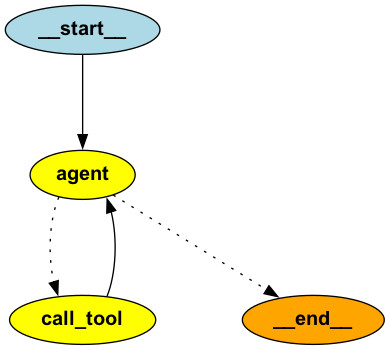

In [22]:
graph_builder = StateGraph(AgentState)

# 添加节点
graph_builder.add_node("agent", agent_node)
graph_builder.add_node("call_tool", tool_node)

# 创建起始节点
graph_builder.set_entry_point("agent")

# 添加条件边
graph_builder.add_conditional_edges(
    "agent",
    router_function,
    {
          "call_tool": "call_tool",
          "__end__": END
    }
)

# 添加边（如果有工具调用，结束后还要回到agent）
graph_builder.add_edge("call_tool", "agent")

# 编译工作流图
tool_agent_app = graph_builder.compile()
print("Tool-using agent graph compiled successfully!")

# 展示工作流图
try:
    from IPython.display import Image, display
    png_img = tool_agent_app.get_graph().draw_png()
    display(Image(png_img))
except Exception as e:
    print(f"Graph visualization failed: {e}. Please ensure pygraphviz is installed.")


Discussion of the Output: The compiled graph is ready. The visualization clearly shows the agent's reasoning loop. The process starts at the agent node. The conditional edge (represented by the diamond) then routes the flow. If a tool is needed, it goes to call_tool, and the output is fed back to the agent for synthesis. If no tool is needed, the process goes to __end__. This structure perfectly implements the Tool Use pattern.

## 3.2 运行工作流

为了测试 Agent 的真实能力，我们将向它提问一个其训练数据中绝对无法包含的问题（例如 2026 年的最新事件），从而强制它必须使用联网搜索工具。

我们将采用**流式传输 (Streaming)** 的方式展示中间步骤，以便实时观察其推理过程的展开。

In [24]:
user_query = "2026年1月6日，凯尔特人和公牛的比赛，杰伦布朗拿了几分？"
initial_input = {"messages": [('user', user_query)]}

console.print(f"[bold cyan]🚀 Kicking off Tool Use workflow for request:[/bold cyan] '{user_query}'\n")

for chunk in tool_agent_app.stream(initial_input, stream_mode="values"):
    chunk["messages"][-1].pretty_print()
    console.print("\n---\n")

console.print("\n[bold green]✅ Tool Use workflow complete![/bold green]")

🚀 Kicking off Tool Use workflow for request: '2026年1月6日，凯尔特人和公牛的比赛，杰伦布朗拿了几分？'

================================ Human Message =================================

2026年1月6日，凯尔特人和公牛的比赛，杰伦布朗拿了几分？


---

--- AGENT: Thinking... ---

--- ROUTER: Decision is to call a tool. ---

================================== Ai Message ==================================
Tool Calls:
  web_search (call_3c532a0188dd4985869719)
 Call ID: call_3c532a0188dd4985869719
  Args:
    query: 2026年1月6日 凯尔特人 公牛 杰伦布朗 得分


---

================================= Tool Message =================================
Name: web_search

[{"title": "杰伦·布朗半场失常，凯尔特人仍领先公牛：数据背后的深度解析 - 搜狐", "url": "https://m.sohu.com/a/972930638_121924582?scm=10001.325_13-325_13.0.0-0-0-0-0.5_1334&spm=smwp.channel_247.block2_307_epwR4p_1_fd.14.1767664800010DA5oXoZ_324", "content": "## 杰伦·布朗半场失常，凯尔特人仍领先公牛：数据背后的深度解析\n\n在刚刚结束的NBA常规赛中，波士顿凯尔特人队以54-33的比分领先于芝加哥公牛队。尽管球队整体表现强势，但核心球员杰伦·布朗却在上半场的表现令人失望，14投仅3中，三分球1投0中，罚球2投1中，最终只得到7分6篮板3助攻，外加2次失误，这样的表现与他前一场比赛轰下50分的火热状态形成鲜明对比。\n\n比赛概述\n\n凯尔特人在本场比赛开始后迅速进入状态，首节就以29-17领先公牛。尽管公牛在第二节试图追赶，但凯尔特人凭借出色的防守和团队配合，始终保持领先。杰伦·布朗在场上的表现则成为了本场比赛的一个小插曲。他的手感冰凉，无法找到得分的节奏，导致球队在进攻端的流畅性受到影响。\n\n杰伦·布朗的表现分析\n\n杰伦·布朗在上半场的表现可谓是“冰火两重天”。在前一场对阵对手时，他的精准投篮和突破能力让对方防不胜防，而本场比赛，他的表现却显得格外挣扎。14次投篮中仅命中3球，命中率仅为21.4%。这样的低迷状态无疑给球队带来了压力。\n\n投篮选择与防守压力 [...] 从数据上看，布朗的投篮选择似乎并不理想。他在三分线外的投篮没有找到手感，尤其是面对公牛的紧逼防守，布朗常常被迫选择高难度的投篮。公牛队的防守策略显然是针对布朗进行的有效布控，让他在进攻端难以找到轻松得分的机会。\n\n传球与失误\n\n尽管布朗在得分方面表现不佳，但他在组织进攻方面仍然发挥了作用，上半场贡献了3次助攻。然而，2次失误则显示出他的决策并不理想。在面对公牛防守的压力时，布朗的传球选择

---

--- AGENT: Thinking... ---

--- ROUTER: Decision is to end the workflow. ---

================================== Ai Message ==================================

根据2026年1月6日凯尔特人对阵公牛的比赛数据，杰伦·布朗全场得到 **14分**。他在比赛中出场35分钟，投篮14投6中，三分球1投1中，罚球1罚1中，同时还贡献了8个篮板、4次助攻和3次失误。


---

✅ Tool Use workflow complete!

# 4、评估 (Evaluation)

对于一个具备工具调用能力的智能体，我们核心关注两点：**它是否正确使用了工具？** 以及 **基于工具输出综合生成的最终答案质量如何？**

## 4.1 分析执行路径 (Analyzing the Execution Path)

通过观察前一步流式输出的链路，我们可以精准追踪智能体的思考过程。输出中展示了在图状态（Graph State）中流转的不同消息类型。

### 📝 执行过程讨论
追踪记录清晰地展示了“工具调用”模式的实际运作：

1.  **节点触发：`agent` 节点**
    * 产生一条包含 `tool_calls` 属性的 `AIMessage`。这证明 LLM 正确判断出需要使用 `web_search` 工具。
2.  **节点触发：`tool` 节点**
    * 产生一条 `ToolMessage`。这是工具执行搜索后返回的原始结果。
3.  **最终输出：`agent` 节点**
    * 再次产生一条 `AIMessage`，但此时不带 `tool_calls`。这表明智能体已将工具返回的信息综合处理，生成了最终答案。



**结论**：这种路径追踪证实了智能体的逻辑和图的路由机制运行完美。

---

## 4.2 通过另一个 LLM 评估生成结果 (Evaluation via Judge LLM)

为了获得更客观、量化的评估，我们将引入一个 **“裁判 (Judge)” LLM**。

### 评估机制
* **结构化评估**：裁判模型会对智能体的表现提供量化的评分。
* **定制准则**：评估标准将专门针对“工具调用质量”进行定制，例如：
    * 工具选择的准确性。
    * 提取信息的全面性。
    * 最终回答的事实对齐度。



---

> **💡 要点**：
> 评估不仅是为了看结果对不对，更是为了验证“过程正确”。通过分析执行路径，我们能发现智能体是否在某个环节出现了无效循环或错误的参数传递。

In [25]:
class ToolUseEvaluation(BaseModel):
    """Schema for evaluating the agent's tool use and final answer."""
    tool_selection_score: int = Field(description="Score 1-5 on whether the agent chose the correct tool for the task.")
    tool_input_score: int = Field(description="Score 1-5 on how well-formed and relevant the input to the tool was.")
    synthesis_quality_score: int = Field(description="Score 1-5 on how well the agent integrated the tool's output into its final answer.")
    justification: str = Field(description="A brief justification for the scores.")

judge_llm = llm.with_structured_output(ToolUseEvaluation)

# 重构对话路径
final_answer = tool_agent_app.invoke(initial_input)
conversation_trace = "\n".join([f"{m.type}: {m.content or ''} {getattr(m, 'tool_calls', '')}" for m in final_answer['messages']])

def evaluate_tool_use(trace: str):
    prompt = f"""You are an expert judge of AI agents. Evaluate the following conversation trace based on the agent's tool use on a scale of 1-5. Provide a brief justification.

    Conversation Trace:
    ```
    {trace}
    ```
    """
    return judge_llm.invoke(prompt)

console.print("--- Evaluating Tool Use Performance ---")
evaluation = evaluate_tool_use(conversation_trace)
console.print(evaluation.model_dump())

--- AGENT: Thinking... ---

--- ROUTER: Decision is to call a tool. ---

--- AGENT: Thinking... ---

--- ROUTER: Decision is to end the workflow. ---

--- Evaluating Tool Use Performance ---

{
    'tool_selection_score': 5,
    'tool_input_score': 5,
    'synthesis_quality_score': 5,
    'justification': '该AI 
agent在处理用户问题时表现优秀。首先，它准确识别出需要查询具体比赛数据的请求，并调用web_search工具进行信息检索，且搜
索关键词精准（包含日期、球队和球员名），有效定位到相关结果。其次，AI从多个来源中提取了关键数据，特别是从虎扑NBA的详
细比赛数据表中获取了杰伦·布朗的完整表现统计，包括得分、投篮、篮板、助攻等核心信息。最终回答不仅给出了正确答案（14分
），还补充了全面的上下文数据，提升了回答的可信度与实用性。整体工具使用合理、高效，信息整合准确，体现了高水平的推理
与信息处理能力。'
}

Discussion of the Output: The LLM-as-a-Judge provides a structured and reasoned assessment of our agent's performance. The high scores across all three categories—tool_selection_score, tool_input_score, and synthesis_quality_score—confirm that our agent is not just using tools, but using them effectively. It correctly identified the need for a web search, formulated a relevant query, and successfully synthesized the retrieved facts into a helpful and accurate final answer. This automated evaluation gives us confidence in the robustness of our implementation.

# 5、结论 (Conclusion)

在这个notebook中，基于 **Tool Use (工具调用)** 架构构建了一个完整且功能齐全的智能体。

### 🎓 核心成果
* **技术栈集成**：成功地为基于 **Langchain-OpenAI** 驱动的 LLM 装备了联网搜索工具。
* **架构实现**：利用 **LangGraph** 构建了一个稳健的推理循环（Reasoning Loop），使智能体能够自主判断何时以及如何使用工具。

### 🌟 模式价值
端到端的执行与随后的评估充分证明了这一模式的巨大价值：
1.  **突破局限**：通过将智能体连接到实时、外部的信息源，我们从根本上克服了“静态训练数据”的时间限制。
2.  **身份转变**：智能体不再仅仅是一个简单的对话者（Reasoner），而变成了一个**研究员 (Researcher)**。它能够提供有据可依、符合事实且紧跟时事的答案。
3.  **应用基石**：这种架构是构建几乎所有实用的、面向现实世界的 AI 助手的核心基石。